In [1]:
import itertools

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.init as init
from torch import nn
from torch import distributions
from torch.distributions import MultivariateNormal

from nflib.flows import MAF, NormalizingFlowModel

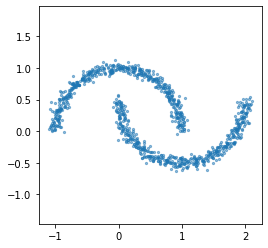

In [2]:
from sklearn import datasets

class TwoHalfMoons:
    def sample(self, n):
        moons = datasets.make_moons(n_samples=n, noise=0.05)[0].astype(np.float32)
        return torch.from_numpy(moons)

d = TwoHalfMoons()

x = d.sample(1024)
plt.figure(figsize=(4,4))
plt.scatter(x[:,0], x[:,1], s=5, alpha=0.5)
plt.axis('equal');

In [3]:
# construct a model
prior = MultivariateNormal(torch.zeros(2), torch.eye(2))

# MAF (with MADE net, so we get very fast density estimation)
flows = [MAF(dim=2, parity=1) for i in range(8)]

#flows = [MAF(dim=2, parity=i%2) for i in range(8)]

# construct the model
model = NormalizingFlowModel(prior, flows)

In [4]:
# optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5) # todo tune WD
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  10976


In [5]:
model.train()
for k in range(10000):
    x = d.sample(256)
    
    zs, prior_logprob, log_det = model(x)
    logprob = prior_logprob + log_det
    loss = -torch.sum(logprob) # NLL

    model.zero_grad()
    loss.backward()
    optimizer.step()

    if k % 100 == 0:
        print(loss.item())


608.646484375
504.0838928222656
458.6304016113281
440.5145263671875
423.8144836425781
410.0059509277344
389.24505615234375
372.2386474609375
351.9622497558594
327.0190734863281
305.12213134765625
283.75140380859375
246.7372283935547
237.66812133789062
245.3515167236328
223.286376953125
198.35552978515625
201.5084991455078
182.98739624023438
173.86843872070312
168.7554168701172
163.05929565429688
173.42526245117188
163.8330078125
171.22540283203125
149.98760986328125
148.36572265625
144.0167236328125
123.78865051269531
138.48074340820312
130.720458984375
123.77989959716797
144.83880615234375
119.35855102539062
117.82496643066406
130.0766143798828
120.48121643066406
114.62625885009766
115.81856536865234
115.77392578125
139.65451049804688
117.69080352783203
100.76414489746094
99.93132781982422
108.68992614746094
95.24989318847656
117.97380828857422
120.62655639648438
94.9480972290039
100.07217407226562
97.97521209716797
110.9529800415039
88.19413757324219
112.33099365234375
121.9776611328

Text(0.5, 1.0, 'x -> z')

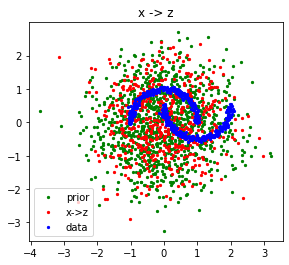

In [6]:
model.eval()

batch_size = 512
x = d.sample(batch_size)
z, prior_logprob, log_det = model(x)

x = x.detach().numpy()
z = z.detach().numpy()
p = model.prior.sample([batch_size, 2]).squeeze()
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(p[:,0], p[:,1], c='g', s=5, label='prior')
plt.scatter(z[:,0], z[:,1], c='r', s=5, label='x->z')
plt.scatter(x[:,0], x[:,1], c='b', s=5, label='data')
plt.legend()

plt.axis('scaled')
plt.title('x -> z')

Text(0.5, 1.0, 'z -> x')

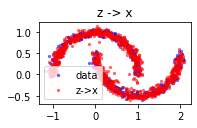

In [7]:
z = model.sample(128*8).detach().numpy()

plt.subplot(122)
plt.scatter(x[:,0], x[:,1], c='b', s=5, alpha=0.5)
plt.scatter(z[:,0], z[:,1], c='r', s=5, alpha=0.5)
plt.legend(['data', 'z->x'])
plt.axis('scaled')
plt.title('z -> x')